In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from sklearn.utils import class_weight
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../../images/", '../../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk
import matplotlib.pyplot as plt

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [8]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [9]:
length = [len(i) for i in tokenized]

(array([3.060e+02, 1.992e+03, 8.900e+02, 3.930e+02, 1.490e+02, 8.000e+01,
        2.500e+01, 3.000e+00, 1.000e+00, 1.000e+00]),
 array([ 2. ,  5.3,  8.6, 11.9, 15.2, 18.5, 21.8, 25.1, 28.4, 31.7, 35. ]),
 <BarContainer object of 10 artists>)

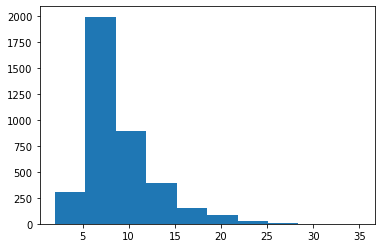

In [10]:
plt.hist([len(i) for i in tokenized])

In [11]:
np.mean(length), np.median(length), np.max(length), np.min(length)

(8.873177083333333, 8.0, 35, 2)

In [12]:
unique_length, counts = np.unique(length, return_counts=True)
list(zip(unique_length, counts))

[(2, 1),
 (3, 19),
 (4, 68),
 (5, 218),
 (6, 526),
 (7, 862),
 (8, 604),
 (9, 437),
 (10, 278),
 (11, 175),
 (12, 143),
 (13, 105),
 (14, 83),
 (15, 62),
 (16, 61),
 (17, 50),
 (18, 38),
 (19, 34),
 (20, 27),
 (21, 19),
 (22, 9),
 (23, 7),
 (24, 5),
 (25, 4),
 (26, 1),
 (27, 1),
 (28, 1),
 (29, 1),
 (35, 1)]

In [13]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [14]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.hstack(tokenized)), np.hstack(tokenized))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/sklearn/utils/validation.py:72: FutureWarning: Pass classes=["'" ',' '-' ... 'youth' 'исходный' 'текст'], y=['the' 'man' 'is' ... 'with' 'some' 'clothes'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  "will result in an error", FutureWarning)


In [15]:
frequency = sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

In [16]:
frequency

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [17]:
len(unique_tokens)

2162

In [18]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [19]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [20]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [151]:
train_images, test_images, train_sequences, test_sequences =  train_test_split(images, tokenized, test_size=0.1, random_state=10)

In [152]:
def sort(images, text):
    length = [len(i) for i in text]
    images, text, _ = zip(*sorted(zip(images, text, length), key = lambda x: x[-1]))
    return images, text

In [153]:
def prepare(images, text, vocab, pad_token, start_token, end_token, batch_size=64):
    images, text = sort(images, text)
    images = np.array(np.array_split(images, len(images)//batch_size))
    text = np.array(np.array_split(text, len(text)//batch_size))
    prepared_text = []
    length = []
    for batched_text in text:
        maxlen = max([len(i) for i in batched_text])
        batch_padded = np.array(list(map(lambda x: [vocab[i] for i in x],padd(batched_text, pad_token, start_token, end_token, maxlen))))
        length.append((batch_padded!=vocab[pad_token]).sum(axis=1)-2)
        prepared_text.append(batch_padded)
    return images, prepared_text, np.array(length)

In [154]:
def padd(sentences, pad_token, start_token, end_token, maxlen=10):
    padded_sentences = []
    for i in sentences:
        sentence = [start_token] + i + [end_token]
        if len(sentence)>=maxlen+2:
            sentence = sentence[:maxlen+2]
        else:
            sentence = sentence+[pad_token for i in range(maxlen+2-len(sentence))]
        padded_sentences.append(sentence)
    return padded_sentences

In [155]:
class_weights = list(class_weights)
class_weights.insert(0, 1)
class_weights.insert(1, 1)
class_weights.insert(2, 1)

In [156]:
len(class_weights), len(vocab)

(2168, 2165)

In [157]:
class_weights[:4]

[1, 1, 1, 1]

In [158]:
class_weights = np.array(class_weights)

In [159]:
class_weights.shape

(2168,)

# Model with transfer learning

In [160]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [161]:
import tensorflow.keras.applications as apps


In [162]:
class ConvEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        #building resnet
        self.resnet_extractor = apps.ResNet152V2(include_top=False, weights='imagenet')
        self.resnet_extractor.trainable = False
        self.pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.dense1 = tf.keras.layers.Dense(units=256, activation='relu')
        self.dense2 = tf.keras.layers.Dense(units=256, activation='relu')
    def call(self, input):
        extracted = self.pooling(self.resnet_extractor(input))
        return [self.dense1(extracted), self.dense2(extracted)]

In [163]:
conv_encoder = ConvEncoder()

In [164]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))

### LSTM model

### making w2v embeddings

In [165]:
!pip install gensim

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [166]:
import gensim.downloader as api

In [167]:
w2v_embeddings = api.load('word2vec-google-news-300')

In [168]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('{} words are out of vocabulary：'.format(count))
    return emb_matrix


In [169]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

22 words are out of vocabulary：


### building model

In [170]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.2)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder', recurrent_dropout=0.3)
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.dropout(self.embeddings(input))
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [171]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1], w2v_embeddings, dim=300)

### Training

In [172]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
lr_value = 1e-4
reduction_power = 10
optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr_value)
with_weights = False

In [173]:
epochs = 20
batch_size = 128
patience_epochs = 2

In [174]:
train_images, train_sequences, train_length = prepare(train_images, train_sequences, vocab, pad_token, start_token, end_token, batch_size=batch_size)

In [175]:
test_images, test_sequences, test_length = prepare(test_images, test_sequences, vocab, pad_token, start_token, end_token, batch_size=batch_size)

In [176]:
def loss_function(real, pred, loss_weights):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)
        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        loss_weights = tf.cast(loss_weights, dtype=loss_.dtype)
        loss_*=loss_weights
        return loss_

In [177]:
train_images.shape, train_sequences[0].shape, train_length.shape 

((27, 128, 224, 224, 3), (128, 7), (27, 128))

In [178]:
test_images.shape, test_sequences[1].shape, test_length.shape 

((3, 128, 224, 224, 3), (128, 11), (3, 128))

In [179]:
!pip install tqdm

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/bin/python -m pip install --upgrade pip' command.


In [180]:
if not with_weights:
    class_weights = np.array([1 for i in range(len(class_weights))])

In [181]:
from tqdm import tqdm

In [182]:
tf.keras.backend.set_floatx('float64')

In [183]:
def generator(images, text, length):
    while True:
        for batched_image, batched_text, batched_length in zip(images, text, length):
            yield batched_image, batched_text, batched_length

In [184]:
train_generator = generator(train_images, train_sequences, train_length)

In [185]:
test_generator = generator(test_images, test_sequences, test_length)

In [186]:
train_images.shape[0]

27

In [187]:
@tf.function
def train_step():
    image, target,lengths =  next(train_generator)
    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
            weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
            weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
            batched_loss.append(loss_function(target[:, t], result, weights))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [188]:
@tf.function
def evaluate():
    image, target, lengths = next(test_generator)
    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)
        weights = tf.broadcast_to(class_weights, shape=(target[:,t].shape[0], class_weights.shape[0]))
        weights = tf.gather(weights, target[:,t],axis=1, batch_dims=1)
        batched_loss.append(loss_function(target[:, t], result, weights))
    
    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)
    perplexity = tf.exp(loss)


    return loss, perplexity

In [189]:
train_loss = []
train_perplexity = []
test_loss = []
test_perplexity = []
overfit_epochs = 0
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_test_loss = 0
    epoch_test_perplexity = 0
    for i in tqdm(range(train_images.shape[0])):
        batched_train_loss, batched_train_perplexity = train_step()
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/train_images.shape[0]
    epoch_train_perplexity = epoch_train_perplexity/train_images.shape[0]
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for i in range(test_images.shape[0]):
        batched_test_loss, batched_test_perplexity = evaluate()
        epoch_test_loss+=batched_test_loss
        epoch_test_perplexity+=batched_test_perplexity
    epoch_test_loss = epoch_test_loss/test_images.shape[0]
    epoch_test_perplexity = epoch_test_perplexity/test_images.shape[0]
    test_perplexity.append(epoch_test_perplexity)
    test_loss.append(epoch_test_loss)
    print('Test loss : {}; Test perplexity : {}'.format(epoch_test_loss,epoch_test_perplexity))
    if len(test_loss)>=2 and test_loss[-2]<test_loss[-1]:
        overfit_epochs+=1
    else:
        overfit_epochs=0
    if overfit_epochs==patience_epochs:
        lr_value/=reduction_power
        optimizer.lr.assign(lr_value)
        print('There was no improvement in test loss for {} epochs, thus reducing learning rate'.format(patience_epochs))

100%|██████████| 27/27 [02:50<00:00,  6.32s/it]


Finished epoch 0; Train loss : 6.664852527418622; Train perplexity : 1391.670211618981


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 6.788491557170414; Test perplexity : 887.573697350717


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 1; Train loss : 4.6801953094631985; Train perplexity : 116.70163410029815


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 6.152235960100023; Test perplexity : 469.7665927116195


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 2; Train loss : 3.5066301541316705; Train perplexity : 34.71902175793387


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.839715781855575; Test perplexity : 343.68164622259536


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 3; Train loss : 2.6411123589957475; Train perplexity : 14.360874417653193


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.639515968856756; Test perplexity : 281.3265147199649


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 4; Train loss : 1.9627045162729229; Train perplexity : 7.226549793377123


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.5182418527558355; Test perplexity : 249.19652763215262


100%|██████████| 27/27 [02:24<00:00,  5.34s/it]


Finished epoch 5; Train loss : 1.4259961187796395; Train perplexity : 4.202526894396205


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.323583647845468; Test perplexity : 205.1176358237166


100%|██████████| 27/27 [02:24<00:00,  5.34s/it]


Finished epoch 6; Train loss : 1.003364785872529; Train perplexity : 2.742361588257922


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.258177487559372; Test perplexity : 192.13101085925663


100%|██████████| 27/27 [02:24<00:00,  5.34s/it]


Finished epoch 7; Train loss : 0.6901364772839266; Train perplexity : 1.9999218904567504


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.239124289532247; Test perplexity : 188.50495434353465


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 8; Train loss : 0.464631585005231; Train perplexity : 1.593802762641686


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.1909660640270365; Test perplexity : 179.64201481895805


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 9; Train loss : 0.3083805634014964; Train perplexity : 1.3622621884701034


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.1594297219843215; Test perplexity : 174.065161760206


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 10; Train loss : 0.20260823839861483; Train perplexity : 1.225072894294524


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.2554739883071475; Test perplexity : 191.6122863167183


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 11; Train loss : 0.13360441945198412; Train perplexity : 1.143177054955195


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.178819159092589; Test perplexity : 177.47311969199882


100%|██████████| 27/27 [02:24<00:00,  5.34s/it]


Finished epoch 12; Train loss : 0.08679660413623357; Train perplexity : 1.0907893225807792


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.338835631044467; Test perplexity : 208.2700658536394


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 13; Train loss : 0.05651632424889142; Train perplexity : 1.0581705954470675


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.282851096553713; Test perplexity : 196.93054370667974


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 14; Train loss : 0.03946506218015674; Train perplexity : 1.0403371908948615


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.399412972543498; Test perplexity : 221.27648269982808


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 15; Train loss : 0.023741953822509793; Train perplexity : 1.0240351083165555


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.469133569911649; Test perplexity : 237.25453921045025
There was no improvement in test loss for 2 epochs, thus reducing learning rate


100%|██████████| 27/27 [02:24<00:00,  5.36s/it]


Finished epoch 16; Train loss : 0.01698071460214797; Train perplexity : 1.0171257487477914


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.479861748438396; Test perplexity : 239.81355048446395


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 17; Train loss : 0.015754053332966582; Train perplexity : 1.0158788899355042


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.494194604135285; Test perplexity : 243.2755141445535


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 18; Train loss : 0.014279561521760588; Train perplexity : 1.014382088480941


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.499404007740824; Test perplexity : 244.54614121619167


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 19; Train loss : 0.012939497297318466; Train perplexity : 1.0130236413466882


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.53783834483264; Test perplexity : 254.12806804019928


100%|██████████| 27/27 [02:24<00:00,  5.35s/it]


Finished epoch 20; Train loss : 0.011763547611415695; Train perplexity : 1.0118330612226611


  0%|          | 0/27 [00:00<?, ?it/s]

Test loss : 5.532573277607528; Test perplexity : 252.7935828380931


  4%|▎         | 1/27 [00:10<04:37, 10.68s/it]


KeyboardInterrupt: 

# Viewing and saving results

In [315]:
df = pd.DataFrame()
model_name = 'conv_lstm_enc_dec_logits_transfer_w2v_resnet_learning_dynamic_length'
df['train_perplexity'] = [i.numpy() for i in train_perplexity]
df['test_perplexity'] = [i.numpy() for i in test_perplexity]
df['train_loss'] = [i.numpy() for i in train_loss]
df['test_loss'] = [i.numpy() for i in test_loss]

In [316]:
df = df[:20]

In [317]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

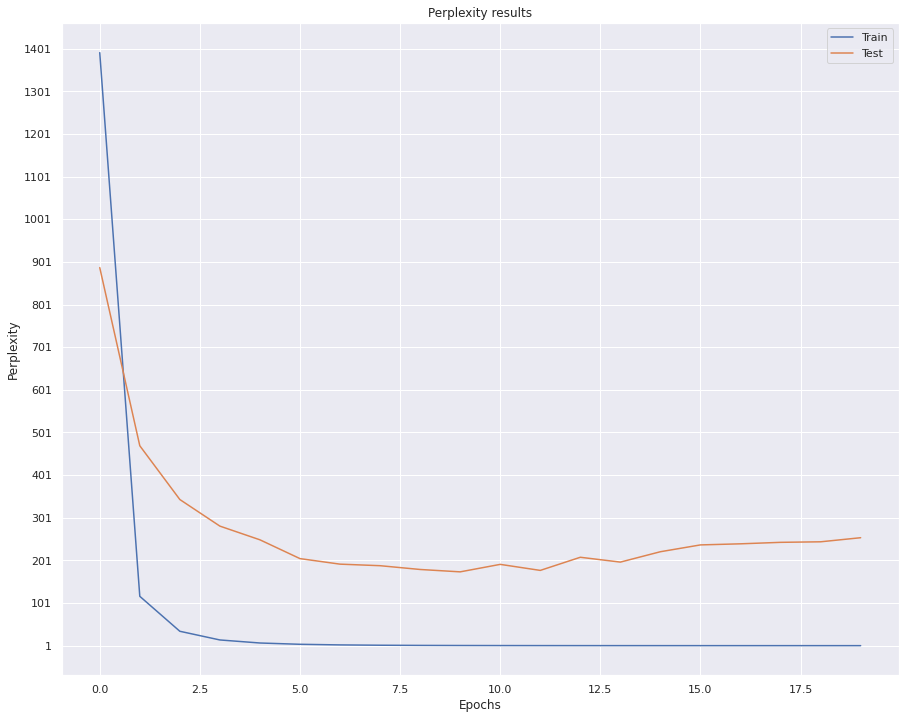

In [318]:
plt.figure(figsize=(15,12))
plt.title('Perplexity results')
plt.plot(df['train_perplexity'])
plt.plot(df['test_perplexity'])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.yticks(np.arange(min(df['train_perplexity']), max(df['train_perplexity'])+100,100))
plt.legend(['Train', 'Test']);

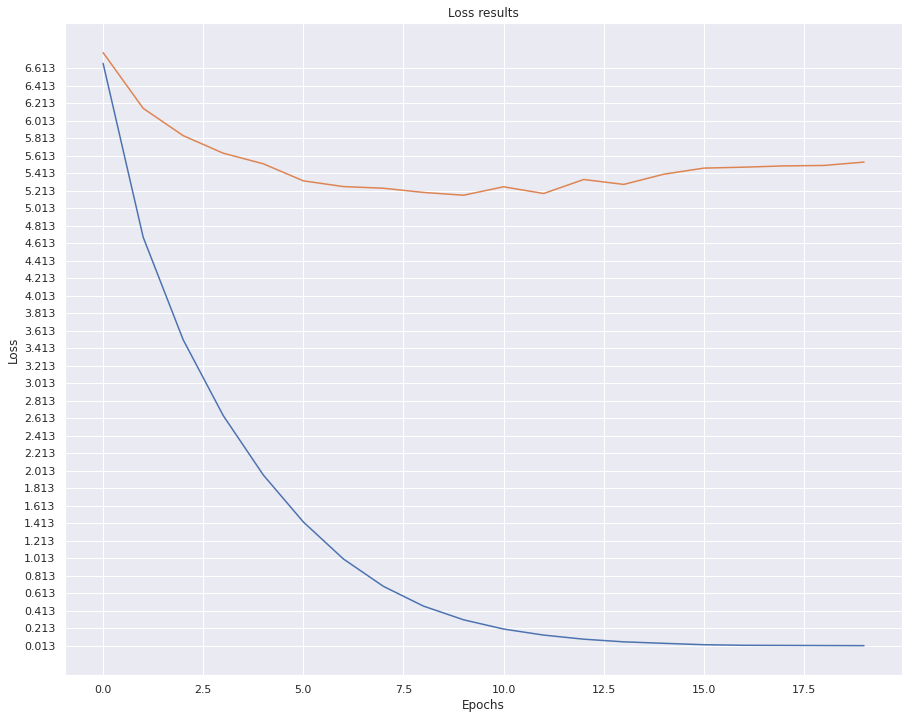

In [319]:
plt.figure(figsize=(15,12))
plt.title('Loss results')
plt.plot(df['train_loss'])
plt.plot(df['test_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss']),max(df['test_loss']),0.2));

# Testing model

In [286]:
import matplotlib.pyplot as plt
import seaborn as sns

In [287]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = None):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len if max_len else 100
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input):
        initial_state = self.encoder(np.expand_dims(input, axis=0))
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token
        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(tf.nn.softmax(output.numpy()))
            if len(res) > self.max_len or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [208]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state = self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [209]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [210]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [211]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=10)

In [212]:
images.shape

(3840, 224, 224, 3)

In [229]:
idx = np.random.choice(range(len(images)))
sample = images[idx]

people are happy and look on a sweetheart couple among them


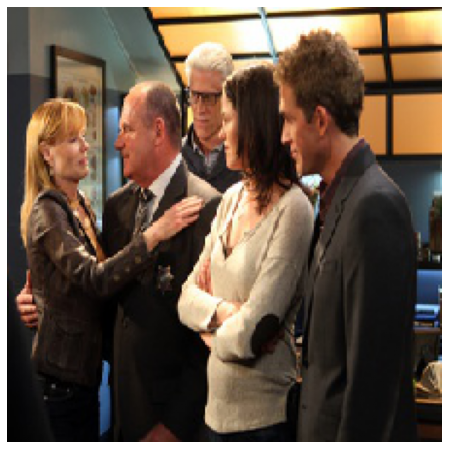

In [230]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');
print(annotations[idx])

In [231]:
predict(sample, greedy_decoder, inverse_vocab)

'the happy couple is hugging'

In [232]:
predict(sample, beam_decoder, inverse_vocab, beam_size=10)

'the happy couple is about something'

# Blue score calculation

In [233]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [234]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 3/3 [04:41<00:00, 93.90s/it]


In [235]:
test_predictions = [i.split(' ') for i in test_predictions]

In [241]:
test_sequences[0].shape

(128, 9)

In [243]:
test_sentences = []
for z in test_sequences:
    for i in z:
        tmp = []
        for word in i:
            if word!=0 and word!=1 and word!=2:
                tmp.append(inverse_vocab[word])
        test_sentences.append(tmp)

In [320]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction))
print('Overall bleu score on test data : {}'.format(np.mean(bleu_score)))
df['overall_bleu'] = np.mean(bleu_score)*100

Overall bleu score on test data : 0.003167339996050436


/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

In [321]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(1,)))
print('Bleu score on test data for n-gram = 1 : {}'.format(np.mean(bleu_score)))
df['n1_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 1 : 0.12279855366272026


In [322]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,1)))
print('Bleu score on test data for n-gram = 2 : {}'.format(np.mean(bleu_score)))
df['n2_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 2 : 0.03147527700248276


In [323]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,1)))
print('Bleu score on test data for n-gram = 3 : {}'.format(np.mean(bleu_score)))
df['n3_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 3 : 0.007994356170813137


In [324]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0,0,0,1)))
print('Bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['n4_bleu'] = np.mean(bleu_score)*100

Bleu score on test data for n-gram = 4 : 0.0023681390014036225


In [325]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu([reference], prediction, weights=(0.25,0.25,0.25,0.25)))
print('Acuumulated bleu score on test data for n-gram = 4 : {}'.format(np.mean(bleu_score)))
df['acc_bleu'] = np.mean(bleu_score)*100

Acuumulated bleu score on test data for n-gram = 4 : 0.003167339996050436


In [326]:
df.head()

,train_perplexity,test_perplexity,train_loss,test_loss,overall_bleu,n1_bleu,n2_bleu,n3_bleu,n4_bleu,acc_bleu
0,1391.670212,887.573697,6.664853,6.788492,0.316734,12.279855,3.147528,0.799436,0.236814,0.316734
1,116.701634,469.766593,4.680195,6.152236,0.316734,12.279855,3.147528,0.799436,0.236814,0.316734
2,34.719022,343.681646,3.506630,5.839716,0.316734,12.279855,3.147528,0.799436,0.236814,0.316734
3,14.360874,281.326515,2.641112,5.639516,0.316734,12.279855,3.147528,0.799436,0.236814,0.316734
4,7.226550,249.196528,1.962705,5.518242,0.316734,12.279855,3.147528,0.799436,0.236814,0.316734


In [327]:
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [333]:
conv_encoder.save_weights('{}_encoder.h5'.format(model_name))

In [334]:
lstm_decoder.save_weights('{}_decoder.h5'.format(model_name))

# Predictions on own data

In [308]:
img = np.array(im.load_img('captioning/download.jpeg', target_size=(224,224)))/255

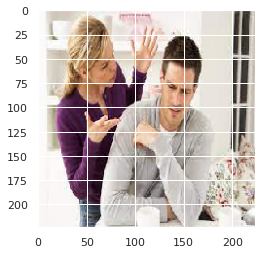

In [309]:
plt.imshow(img)

In [310]:
predict(img, greedy_decoder, inverse_vocab)

'woman looks upset and disappointed'

In [314]:
predict(img, beam_decoder, inverse_vocab, beam_size=7)

'woman looks upset and disappointed'